In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff
import datetime
# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
# from xgboost import XGBClassifier
# import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
from tqdm import tqdm
print(os.listdir("../input/ieee-fraud-detection"))

['train_identity.csv', 'train_transaction.csv', 'test_transaction.csv', 'test_identity.csv', 'sample_submission.csv']


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in tqdm(df.columns):
        col_type = df[col].dtype
        #print(col_type)
        if str(col_type)[:4]== 'date' : continue
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
train = pd.read_pickle('../input/datas4/train2.pkl')
test  = pd.read_pickle('../input/datas4/test2.pkl')
sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')

In [4]:
print('Memory usage of train is {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Memory usage of test is {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))

Memory usage of train is 1385.45 MB
Memory usage of test is 1195.99 MB


In [5]:
# DATE_COLS = ['D{}'.format(i) for i in range(1, 16) if i != 9]
# DATE_COLS.remove('D7')
# # df['UniqueDates'] = df[DATE_COLS].nunique(axis=1)
# train = ['UniqueDates'] = train[DATE_COLS].nunique(axis=1)
# test = ['UniqueDates'] = test[DATE_COLS].nunique(axis=1)


In [6]:
train['nulls'] = train.isnull().sum(axis=1)
test['nulls'] = test.isnull().sum(axis=1)

In [7]:
# for col in ['uid3']:
#     temp_dict = train.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
#                                                         columns={'mean': col+'_isFraud'})
#     temp_dict.index = temp_dict[col].values
#     temp_dict = temp_dict[col+'_isFraud'].to_dict()

#     train[col+'_isFraud'] = train[col].map(temp_dict).astype('float16')
#     test[col+'_isFraud']  = test[col].map(temp_dict).astype('float16')
    
#     train[col+'_isFraud'] = train[col+'_isFraud'].map(lambda x : 1 if x>0.95 else 0)
#     test[col+'_isFraud'] = test[col+'_isFraud'].map(lambda x : 1 if x>0.95 else 0)
    

In [8]:
def plot_numerical(feature):
    """
    Plot some information about a numerical feature for both train and test set.
    Args:
        feature (str): name of the column in DataFrame
    """
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
    sns.kdeplot(train[feature], ax=axes[0][0], label='Train');
    sns.kdeplot(test[feature], ax=axes[0][0], label='Test');

    sns.kdeplot(train[train['isFraud']==0][feature], ax=axes[0][1], label='isFraud 0')
    sns.kdeplot(train[train['isFraud']==1][feature], ax=axes[0][1], label='isFraud 1')

    test[feature].index += len(train)
    axes[1][0].plot(train[feature], '.', label='Train');
    axes[1][0].plot(test[feature], '.', label='Test');
    axes[1][0].set_xlabel('row index');
    axes[1][0].legend()
    test[feature].index -= len(train)

    axes[1][1].plot(train[train['isFraud']==0][feature], '.', label='isFraud 0');
    axes[1][1].plot(train[train['isFraud']==1][feature], '.', label='isFraud 1');
    axes[1][1].set_xlabel('row index');
    axes[1][1].legend()

    pd.DataFrame({'train': [train[feature].isnull().sum()], 'test': [test[feature].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[2][0]);
    pd.DataFrame({'isFraud 0': [train[(train['isFraud']==0) & (train[feature].isnull())][feature].shape[0]],
                  'isFraud 1': [train[(train['isFraud']==1) & (train[feature].isnull())][feature].shape[0]]}).plot(kind='bar', rot=0, ax=axes[2][1]);

    fig.suptitle(feature, fontsize=18);
    axes[0][0].set_title('Train/Test KDE distribution');
    axes[0][1].set_title('Target value KDE distribution');
    axes[1][0].set_title('Index versus value: Train/Test distribution');
    axes[1][1].set_title('Index versus value: Target distribution');
    axes[2][0].set_title('Number of NaNs');
    axes[2][1].set_title('Target value distribution among NaN values');
    
# This code is stolen from Chris Deotte. 
def relax_data(df_train, df_test, col):
    cv1 = pd.DataFrame(df_train[col].value_counts().reset_index().rename({col:'train'},axis=1))
    cv2 = pd.DataFrame(df_test[col].value_counts().reset_index().rename({col:'test'},axis=1))
    cv3 = pd.merge(cv1,cv2,on='index',how='outer')
    factor = len(df_test)/len(df_train)
    cv3['train'].fillna(0,inplace=True)
    cv3['test'].fillna(0,inplace=True)
    cv3['remove'] = False
    cv3['remove'] = cv3['remove'] | (cv3['train'] < len(df_train)/10000)
    cv3['remove'] = cv3['remove'] | (factor*cv3['train'] < cv3['test']/3)
    cv3['remove'] = cv3['remove'] | (factor*cv3['train'] > 3*cv3['test'])
    cv3['new'] = cv3.apply(lambda x: x['index'] if x['remove']==False else 0,axis=1)
    cv3['new'],_ = cv3['new'].factorize(sort=True)
    cv3.set_index('index',inplace=True)
    cc = cv3['new'].to_dict()
    df_train[col] = df_train[col].map(cc)
    df_test[col] = df_test[col].map(cc)
    return df_train, df_test

In [9]:
list(train.columns)

# #train = train.drop(['uid','uid2','uid3','uid4','uid5'],axis =1)
# #test = test.drop(['uid','uid2','uid3','uid4','uid5'],axis =1)

# train = train.drop(['card1','card2','card3','card4','card5','card6'],axis =1)
# test = test.drop(['card1','card2','card3','card4','card5','card6'],axis =1)

# train = train.drop(['ProductCD'],axis =1)
# test = test.drop(['ProductCD'],axis =1)



['isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83

In [10]:
Y_train = train['isFraud'].copy()

X_train = train.drop('isFraud', axis=1)
print(X_train.shape)
X_train.drop('TransactionDT', axis=1, inplace=True)
print(X_train.shape)
X_test = test.drop('TransactionDT', axis=1) 
print(X_test.shape)

train, test = None, None
del train, test
gc.collect()


(590540, 582)
(590540, 581)
(506691, 581)


0

In [11]:
numerical_columns = list(X_train.select_dtypes(include=['float16','float32','float64','int8','int16','int64']).columns)

#list(test.select_dtypes(exclude=['object']).columns)
print(X_train.shape)
X_train[numerical_columns] =X_train[numerical_columns].fillna(X_train[numerical_columns].median())
X_test[numerical_columns] =X_test[numerical_columns].fillna(X_test[numerical_columns].median())
print("filling numerical columns null values done")
# print(X_train.shape)

(590540, 581)
filling numerical columns null values done


In [12]:
categorical_columns = list(filter(lambda x: x not in numerical_columns, list(X_train.columns)))
categorical_columns[:5]
X_train[categorical_columns] =X_train[categorical_columns].fillna(X_train[categorical_columns].mode())
X_test[categorical_columns] =X_test[categorical_columns].fillna(X_test[categorical_columns].mode())
print("filling numerical columns null values done")

filling numerical columns null values done


In [13]:
for f in X_train.select_dtypes(include='category').columns.tolist() + X_train.select_dtypes(include='object').columns.tolist():
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(X_train[f].values) + list(X_test[f].values))
    X_train[f] = lbl.transform(list(X_train[f].values))
    X_test[f] = lbl.transform(list(X_test[f].values))

In [14]:
print(X_train.shape)

(590540, 581)


In [15]:
# one_value_cols = [col for col in X_train.columns if X_train[col].nunique() <= 1]
# one_value_cols_X_test = [col for col in X_test.columns if X_test[col].nunique() <= 1]

# many_null_cols = [col for col in X_train.columns if X_train[col].isnull().sum() / X_train.shape[0] > 0.8]
# many_null_cols_X_test = [col for col in X_test.columns if X_test[col].isnull().sum() / X_test.shape[0] > 0.8]
# print(many_null_cols)

# big_top_value_cols = [col for col in X_train.columns if X_train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
# big_top_value_cols_X_test = [col for col in X_test.columns if X_test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

# cols_to_drop = list(set(many_null_cols + many_null_cols_X_test + big_top_value_cols + big_top_value_cols_X_test + one_value_cols+ one_value_cols_X_test))
# print(len(cols_to_drop))
# print(cols_to_drop)
# X_train.drop(cols_to_drop, axis=1, inplace=True)
# X_test.drop(cols_to_drop, axis=1, inplace=True)


In [16]:
print(X_train.shape)

(590540, 581)


In [17]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)
gc.collect()


  2%|▏         | 12/581 [00:00<00:04, 119.26it/s]

Memory usage of dataframe is 1517.50 MB


  3%|▎         | 15/581 [00:00<00:03, 146.83it/s]

Memory usage after optimization is: 977.41 MB
Decreased by 35.6%
Memory usage of dataframe is 1312.61 MB


100%|██████████| 581/581 [00:21<00:00, 27.00it/s]

Memory usage after optimization is: 855.00 MB
Decreased by 34.9%


0

In [18]:
categorical_features = ['ProductCD','M4',
                        'card1','card2','card3','card4','card5','card6',
                        'addr1','addr2','dist1','dist2',
                        'P_emaildomain','R_emaildomain',
                       ]
categorical_features +=['M1_9', 'uid1', 'uid2', 'uid3', 'uid4', 'uid6', 'uid7', 'uid8', 'uid9', 'uid10', 'V1_11', 'V35_52', 'V75_94',
                         'card1_addr1','id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13',
                         'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32', 'id_03_04', 'id_05_06',
                     'id_07_08', 'id_35_38', 'id_17_20_ip1', 'id_21_22_ip2', 'id_24_26_ip3','TransactionAmt_grouping', 'dayofyear_block', 'hours_block',
                   
                       ]
categorical_features = list(set(categorical_features))

In [19]:
# X_train['DayOfYear']

In [20]:
for col in ['D15','D10','D8','D2']:
    X_train[col] = np.where(X_train[col]==-999,0,X_train[col])
    X_test[col] = np.where(X_test[col]==-999,0,X_test[col])
    
X_train['D16'] = X_train['D15']
X_train['D16'] = np.where(X_train['D16']>0, X_train['D16'],X_train['D10'])
X_train['D16'] = np.where(X_train['D16']>0, X_train['D16'],X_train['D8'])
X_train['D16'] = np.where(X_train['D16']>0, X_train['D16'],X_train['D2'])
# X_train['D16'].values[:100]

X_test['D16'] = X_test['D15']
X_test['D16'] = np.where(X_test['D16']>0, X_test['D16'],X_test['D10'])
X_test['D16'] = np.where(X_test['D16']>0, X_test['D16'],X_test['D8'])
X_test['D16'] = np.where(X_test['D16']>0, X_test['D16'],X_test['D2'])

for col in ['D15','D10','D8','D2']:
    X_train[col] = X_train[col].fillna(-999)
    X_test[col] = X_test[col].fillna(-999)

In [21]:
# 시작점부터의 일수 계산
fromstart = []
tmp = 0
x =1
dayofyears = list(X_train['DayOfYear'])+list(X_test['DayOfYear']) 
for i in tqdm(range(len(dayofyears))) :
#     print(tmp, X_train['dayofyear'].iloc[i])
    if fromstart ==[] : fromstart.append(x)
    else :
        if tmp == dayofyears[i] : fromstart.append(x)
        else : 
            x += 1
            fromstart.append(x)
    tmp = dayofyears[i]

X_train['fromstart'] = fromstart[:X_train.shape[0]]
X_test['fromstart'] = fromstart[X_train.shape[0]:]


X_train['grouping'] = (X_train['D16']- X_train['fromstart'])/10
X_train['grouping'] = np.round(X_train['grouping'])

X_test['grouping'] = (X_test['D16']- X_test['fromstart'])/10
X_test['grouping'] = np.round(X_test['grouping'])

100%|██████████| 1097231/1097231 [00:00<00:00, 1365172.80it/s]


In [22]:
# Some arbitrary features interaction
features = ['uid4__grouping']
#[ 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
#                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']
# features = features[:6]
print(features)
from sklearn import preprocessing
for feature in features:

    f1, f2 = feature.split('__')
    X_train[feature] = X_train[f1].astype(str) + '_' + X_train[f2].astype(str)
    X_test[feature] = X_test[f1].astype(str) + '_' + X_test[f2].astype(str)
    categorical_features.append(feature)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(X_train[feature].values) + list(X_test[feature].values))
    X_train[feature] = lbl.transform(list(X_train[feature].values))
    X_test[feature] = lbl.transform(list(X_test[feature].values))
    
    

['uid4__grouping']


In [23]:
# # https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/77537
# # CV 와 LB 사이의 GAP 줄이기
# from scipy.stats import ks_2samp
# list_p_value =[]

# cols = [x for x in X_train.columns if x not in categorical_features]
# for i in tqdm(cols):
#     list_p_value.append(ks_2samp(X_test[i] , X_train[i])[1])

# Se = pd.Series(list_p_value, index = cols).sort_values() 
# list_discarded = list(Se[Se == 0].index)
# # len(list_discarded)
# #if 'dayofyear' in list_discarded :list_discarded.remove('dayofyear')
# X_train = X_train.drop(list_discarded,axis =1 )
# X_test = X_test.drop(list_discarded,axis =1 )
# print(list_discarded)

In [24]:
# # # Create correlation matrix
# drop_cols = []
# for df in tqdm([X_train,X_test]):
#     corr_matrix = df.corr().abs()
#     # Select upper triangle of correlation matrix
#     upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#     # Find index of feature columns with correlation greater than 0.95
#     drop_cols += [column for column in upper.columns if any(upper[column] > 0.98)]
# drop_cols =list(set(drop_cols))
# print(drop_cols)
# gc.collect()
# # if 'dayofyear' in drop_cols :drop_cols.remove('dayofyear')
# X_train = X_train.drop(drop_cols,axis =1 )
# X_test = X_test.drop(drop_cols,axis =1 )

In [25]:
print(X_train.shape)

(590540, 585)


In [26]:
# selcols = pd.read_csv('../input/columns/fianl_x.csv')
# selcols = list(selcols['0'])
# delcols  = pd.read_csv('../input/columns/delete_x.csv')
# delcols = list(delcols['0'])

In [27]:
# # randomforest로 Overfit 된 것 찾기
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=99)
# final_x, features = selcols,delcols
# cols = [x for x in list(X_train.columns) if x not in selcols+delcols]
# aucs = 0
# delcols = delcols
# for i,col in enumerate(cols):
#     print(i, features, col)
#     features.append('%s'%col)
#     x_t, x_v = x_train[features],x_valid[features]
#     # Create a random forest classifier
#     clf = RandomForestClassifier(n_estimators=200, random_state=99, n_jobs=-1 )
#     # Train the classifier
#     clf.fit(x_t.astype('float32'), y_train.astype('float32'))
#     auc = roc_auc_score(y_valid, clf.predict(x_v))
#     print("pre_auc " , aucs, "auc " , auc)
#     if aucs < auc : 
#         aucs = auc
#         final_x.append(col)
#     else :
#         delcols.append(col)
#     pd.DataFrame(final_x).to_csv('final_x.csv')
#     pd.DataFrame(delcols).to_csv('delete_x.csv')
        
# del x_train,x_valid,y_train, y_valid 
# gc.collect()

# X_train = reduce_mem_usage(X_train[final_x])
# X_test = reduce_mem_usage(X_test[final_x])
# gc.collect()
# print(X_train.shape)

In [28]:
# X_train = X_train.drop(delcols, axis =1)
# X_test = X_test.drop(delcols, axis =1)
# gc.collect()
# print(X_train.shape)

In [29]:
# Hyperparameter 찾기

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization

In [30]:
import multiprocessing
seed=120
def train_model(learning_rate,num_leaves, min_data_in_leaf, bagging_fraction, feature_fraction, lambda_l1, lambda_l2,max_bin,min_child_weight):
    print("############## New Run ################")
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': 4,
        'learning_rate': learning_rate,#0.01, # learning rate
        'num_iterations' : 200,#3000,
        #'n_estimators' : 800,
        'num_leaves': int(num_leaves),
        'min_data_in_leaf': int(min_data_in_leaf),
        'max_depth': -1,#int(max_depth),
        'bagging_fraction' : bagging_fraction,
        'feature_fraction' : feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'max_bin' : int(max_bin),
        'min_child_weight': min_child_weight,
        'bagging_seed' : 11,
        #'early_stopping_round' : 50,
        'verbose' : -1,
        'seed' :seed
    }
    print("PARAMETERS: ")
    print(f"params  = {params}")
    
    tscv =  StratifiedKFold(n_splits=5, shuffle=True, random_state=42)#KFold(n_splits=5)#StratifiedKFold(n_splits=5)#TimeSeriesSplit(n_splits=3)
    sc = []
#     for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    for fold_,(train_idx, test_idx) in enumerate(tscv.split(X_train, Y_train)):
#         print( Y_train.iloc[train_idx].head())
        x_train, x_val = X_train.iloc[train_idx,:], X_train.iloc[test_idx,:]
        y_train, y_val = Y_train.iloc[train_idx], Y_train.iloc[test_idx]
        
        sc2 =[]
        N = 1
    #         Data Augmentation Test
        print(x_train.shape)
        #X_t, y_t = augment(x_train.values, y_train.values)
#         with multiprocessing.Pool() as pool:
#             X_t = pool.map(reduce_mem_usage, pd.DataFrame(X_t))
       # X_t = reduce_mem_usage(pd.DataFrame(X_t))
        lgb_train = lgb.Dataset(x_train.astype('float32'), label=y_train.astype('float32'))
        lgb_valid = lgb.Dataset(data=x_val.astype('float32'), label=y_val.astype('float32'))
        
        gc.collect()
        
        for i in range(N):
            
             # augmentation 한 것            
            lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_valid, verbose_eval=200,early_stopping_rounds=50)
            y = lgb_model.predict(x_train.astype('float32'), num_iteration=lgb_model.best_iteration)
            train_score = roc_auc_score(y_train.astype('float32'), y)        
            y = lgb_model.predict(x_val.astype('float32'), num_iteration=lgb_model.best_iteration)
            score = roc_auc_score(y_val.astype('float32'), y)
            print ("Fold : ", fold_,"Number : ", i, "train_auc : ",train_score,"val_auc : ", score)
            sc2.append(score)
            del lgb_model 
            gc.collect()
        sc.append(np.mean(sc2))
        #############################
#         lgb_train = lgb.Dataset(data=x_train.astype('float32'), label=y_train.astype('float32'))
#         lgb_valid = lgb.Dataset(data=x_val.astype('float32'), label=y_val.astype('float32'))
        
        
#         lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_valid, verbose_eval=500)
#         y = lgb_model.predict(x_train.astype('float32'), num_iteration=lgb_model.best_iteration)
#         train_score = roc_auc_score(y_train.astype('float32'), y)        
#         y = lgb_model.predict(x_val.astype('float32'), num_iteration=lgb_model.best_iteration)
#         score = roc_auc_score(y_val.astype('float32'), y)
#         print ("Fold : ", fold_,"train_auc : ",train_score,"val_auc : ", score)
#         sc.append(score)
        
    paralst.append(params)
    scorelst.append(np.mean(sc))
    df_para = pd.DataFrame({"parameter" :paralst,"score":scorelst})
    print(df_para)
    df_para.to_csv('para.csv',index=False)

        
    return np.mean(sc)

bounds = {
    'num_leaves': (1300,1600),#(450, 500),
    'min_data_in_leaf': (0,100),#(100, 150),
    #'max_depth': -1,#(-1, 50), # -> -1
    'learning_rate': (0.005,0.01),#0.006883242363721497,
    'bagging_fraction' : (0.3, 0.5),
    'feature_fraction' : (0.1, 0.4),
    'lambda_l1': (0.3, 0.5),
    'lambda_l2': (0.3, 0.7),
    'max_bin' : (150,255), # 추가
    'min_child_weight': (0.01, 0.05),
}

traintime = False#True
if traintime :
    paralst,scorelst = [],[]
    bo = BayesianOptimization(train_model, bounds, random_state= seed)
    bo.maximize(init_points=3, n_iter=30, acq='ucb', xi=0.0, alpha=1e-6)
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': 4,
        'bagging_seed' : 11,
        'learning_rate':bo.max['params']['learning_rate'],#0.01,
        'n_estimators' : 500,#3000,
        'num_leaves': int(bo.max['params']['num_leaves']),
        'min_data_in_leaf': int(bo.max['params']['min_data_in_leaf']),
        'max_depth': -1,#int(bo.max['params']['max_depth']),
        'bagging_fraction' : bo.max['params']['bagging_fraction'],
        'feature_fraction' : bo.max['params']['feature_fraction'],
        'lambda_l1': bo.max['params']['lambda_l1'],
        'lambda_l2': bo.max['params']['lambda_l2'],
        'max_bin' : bo.max['params']['max_bin'],
        'min_child_weight' :  bo.max['params']['min_child_weight'],
       #'early_stopping_round' : 50,
        'verbose' : -1,
        'seed' :seed

    }
    print(params)

In [31]:
folds = 5
if not traintime :  
     #0.9487
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.018903235195922664, 'num_iterations': 10000, 'num_leaves': 1304, 'min_data_in_leaf': 1, 'max_depth': -1, 'bagging_fraction': 0.48133708623585175, 'feature_fraction': 0.3930678252599681, 'lambda_l1': 0.33003972170901036, 'lambda_l2': 0.48380640349706283, 'max_bin': 151, 'min_child_weight': 0.02382942159168059, 'bagging_seed': 11, 'verbose': -1, 'seed': 35} #0.9654
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.018236177415832534, 'num_iterations':10000, 'num_leaves': 1598, 'min_data_in_leaf': 3, 'max_depth': -1, 'bagging_fraction': 0.4543823845071219, 'feature_fraction': 0.38901411294365906, 'lambda_l1': 0.3320275264241193, 'lambda_l2': 0.441667319239131, 'max_bin': 150, 'min_child_weight': 0.02892164068243388, 'bagging_seed': 11, 'verbose': -1, 'seed': 120} #0.9651
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.018904873086818035, 'num_iterations': 10000, 'num_leaves': 1578, 'min_data_in_leaf': 0, 'max_depth': -1, 'bagging_fraction': 0.48856529593796316, 'feature_fraction': 0.3127401145699429, 'lambda_l1': 0.3433175326027915, 'lambda_l2': 0.4315465577396091, 'max_bin': 253, 'min_child_weight': 0.0479085834818095, 'bagging_seed': 11, 'verbose': -1, 'seed': 12} #0.96485
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.0187731591133625, 'num_iterations': 3000, 'num_leaves': 1598, 'min_data_in_leaf': 0, 'max_depth': -1, 'bagging_fraction': 0.47905338286545424, 'feature_fraction': 0.35087371236650544, 'lambda_l1': 0.4609110771693348, 'lambda_l2': 0.4429443255980836, 'max_bin': 246, 'min_child_weight': 0.037410120970604165, 'bagging_seed': 11, 'verbose': -1, 'seed': 99} #0.96461
    #0.9471 -> 0.9469
  #  params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.014645596881635362, 'num_iterations': 3000, 'num_leaves': 1385, 'min_data_in_leaf': 2, 'max_depth': -1, 'bagging_fraction': 0.38470656275266424, 'feature_fraction': 0.3963200069886693, 'lambda_l1': 0.3620323536611625, 'lambda_l2': 0.35373332136972424, 'max_bin': 154, 'min_child_weight': 0.04295077705493547, 'bagging_seed': 11, 'verbose': -1, 'seed': 12}#0.96069
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.014960621900450888, 'num_iterations': 3000, 'num_leaves': 1395, 'min_data_in_leaf': 0, 'max_depth': -1, 'bagging_fraction': 0.34044595394766747, 'feature_fraction': 0.34214407482513476, 'lambda_l1': 0.4805008954626611, 'lambda_l2': 0.37118265029595326, 'max_bin': 245, 'min_child_weight': 0.029364491351868728, 'bagging_seed': 11, 'verbose': -1, 'seed': 399} #0.960682
    
    
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.009833261038853328, 'num_iterations': 10000, 'num_leaves': 1149, 'min_data_in_leaf': 49, 'max_depth': -1, 'bagging_fraction': 0.3240951596739299, 'feature_fraction': 0.3498407985953037, 'lambda_l1': 0.3501312050658983, 'lambda_l2': 0.31690592587909633, 'max_bin': 161, 'min_child_weight': 0.0114896062770591, 'bagging_seed': 11, 'verbose': -1, 'seed': 99} #0.92151
#     params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.009754414928876673, 'num_iterations': 10000, 'num_leaves': 1143, 'min_data_in_leaf': 35, 'max_depth': -1, 'bagging_fraction': 0.3554679818433634, 'feature_fraction': 0.3402175958274567, 'lambda_l1': 0.34752046110782797, 'lambda_l2': 0.37744033227254215, 'max_bin': 242, 'min_child_weight': 0.03617820556477377, 'bagging_seed': 11, 'verbose': -1, 'seed': 165} #0.921416
    #0.9474 -> 0.9471 -> 0.9492 CV: 0.976609
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.008872937600948674, 'num_iterations': 10000, 'num_leaves': 999, 'min_data_in_leaf': 10, 'max_depth': -1, 'bagging_fraction': 0.4713288697981503, 'feature_fraction': 0.39018895127170683, 'lambda_l1': 0.3510394531977163, 'lambda_l2': 0.3873703557388186, 'max_bin': 254, 'min_child_weight': 0.033084878554612146, 'bagging_seed': 11, 'verbose': -1, 'seed': 12} #0.919813
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.008976158898617054, 'num_iterations': 10000, 'num_leaves': 995, 'min_data_in_leaf': 14, 'max_depth': -1, 'bagging_fraction': 0.4682934735568483, 'feature_fraction': 0.3965931325683636, 'lambda_l1': 0.3760099829112723, 'lambda_l2': 0.3975897064215117, 'max_bin': 254, 'min_child_weight': 0.02847878240902596, 'bagging_seed': 11, 'verbose': -1, 'seed': 277} #0.919887
    #0.9465
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.00898758545742255, 'num_iterations': 10000, 'num_leaves': 924, 'min_data_in_leaf': 14, 'max_depth': -1, 'bagging_fraction': 0.4024823598624291, 'feature_fraction': 0.3208499817534414, 'lambda_l1': 0.46115302747432046, 'lambda_l2': 0.35539565704287, 'max_bin': 250, 'min_child_weight': 0.04355005924028087, 'bagging_seed': 11, 'verbose': -1, 'seed': 399} #0.91827
    #0.9467
    #params ={'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007972931513741082, 'num_iterations': 10000, 'num_leaves': 799, 'min_data_in_leaf': 1, 'max_depth': -1, 'bagging_fraction': 0.4895500948839138, 'feature_fraction': 0.37387418327918154, 'lambda_l1': 0.41482044398244905, 'lambda_l2': 0.5362091922107519, 'min_child_weight': 0.021811137046946497, 'bagging_seed': 11, 'verbose': -1, 'seed': 132} #0.916263
    #Best 0.9469 -> 0.9473 -> 0.9474 -> 0.9492 : Best CV 0.9769
    params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007898644187072399, 'num_iterations': 10000, 'num_leaves': 785, 'min_data_in_leaf': 8, 'max_depth': -1, 'bagging_fraction': 0.395331230891172, 'feature_fraction': 0.31552276732000295, 'lambda_l1': 0.3470087563049069, 'lambda_l2': 0.503276501340582, 'min_child_weight': 0.03208937707510653, 'bagging_seed': 11, 'verbose': -1, 'seed': 99} #0.916033
   
   
  #params = {'objective': 'binary', 'num_threads': 4, 'learning_rate': 0.007898644187072399, 'num_iterations': 10000, 'num_leaves': 785, 'min_data_in_leaf': 8, 'max_depth': -1, 'bagging_fraction': 0.395331230891172, 'feature_fraction':1, 'lambda_l1': 0.3470087563049069, 'lambda_l2': 0.503276501340582, 'min_child_weight': 0.03208937707510653, 'bagging_seed': 11, 'verbose': -1, 'seed': 99} #0.916033
   # params = {'objective': 'binary', 'num_threads': 4, 'learning_rate': 0.007898644187072399, 'num_iterations': 10000, 'num_leaves': 785, 'min_data_in_leaf': 8, 'max_depth': -1, 'bagging_fraction': 0.395331230891172, 'feature_fraction': 0.31552276732000295, 'lambda_l1': 0.3470087563049069, 'lambda_l2': 0.503276501340582, 'min_child_weight': 0.03208937707510653, 'bagging_seed': 11, 'verbose': -1, 'seed': 99} #0.916033
    
    #test
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007898644187072399, 'num_iterations': 10000, 'num_leaves': 512, 'min_data_in_leaf': 8, 'max_depth': -1, 'bagging_fraction': 0.395331230891172, 'feature_fraction': 0.31552276732000295, 'lambda_l1': 0.3470087563049069, 'lambda_l2': 0.503276501340582, 'min_child_weight': 0.03208937707510653, 'bagging_seed': 11, 'verbose': -1, 'seed': 99} #0.916033
   
    #0.9468
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007899687615149507, 'num_iterations': 3000, 'num_leaves': 799, 'min_data_in_leaf': 0, 'max_depth': -1, 'bagging_fraction': 0.33041506218684263, 'feature_fraction': 0.35416575497676395, 'lambda_l1': 0.38704306154857826, 'lambda_l2': 0.5178012092942015, 'min_child_weight': 0.026728352023513757, 'bagging_seed': 11, 'verbose': -1, 'seed': 12} #0.916009
    # 0.9467
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007372873282822138, 'num_iterations': 3000, 'num_leaves': 599, 'min_data_in_leaf': 50, 'max_depth': -1, 'bagging_fraction': 0.38244660605863556, 'feature_fraction': 0.44257840443437824, 'lambda_l1': 0.45420352424554195, 'lambda_l2': 0.5105273366387331, 'min_child_weight': 0.04533307349626744, 'bagging_seed': 11, 'verbose': -1, 'seed': 160} #0.9131
    # 0.9465
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007203449399886559, 'num_iterations': 3000, 'num_leaves': 599, 'min_data_in_leaf': 50, 'max_depth': -1, 'bagging_fraction': 0.38525498446643613, 'feature_fraction': 0.380367681990148, 'lambda_l1': 0.34523297270543946, 'lambda_l2': 0.5734926679250656, 'min_child_weight': 0.02678622651731609, 'bagging_seed': 11, 'verbose': -1, 'seed': 160} #0.913067
    #0.9460이하
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.006990904355014822, 'num_iterations': 3000, 'num_leaves': 499, 'min_data_in_leaf': 100, 'max_depth': -1, 'bagging_fraction': 0.3812981748987723, 'feature_fraction': 0.47302209023435043, 'lambda_l1': 0.4631415001252107, 'lambda_l2': 0.5618020019879593, 'min_child_weight': 0.043917717737188104, 'bagging_seed': 11, 'verbose': -1, 'seed': 105} # 0.909427
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.006787730751128605, 'num_iterations': 3000, 'num_leaves': 499, 'min_data_in_leaf': 100, 'max_depth': -1, 'bagging_fraction': 0.47560044639915244, 'feature_fraction': 0.41666150781008676, 'lambda_l1': 0.47548378689674464, 'lambda_l2': 0.9757213490246281, 'min_child_weight': 0.041972701015528587, 'bagging_seed': 11, 'verbose': -1, 'seed': 105} # 0.909053
    #params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.006882517225047709, 'num_iterations': 3000, 'num_leaves': 499, 'min_data_in_leaf': 100, 'max_depth': -1, 'bagging_fraction': 0.4237390751101919, 'feature_fraction': 0.43926420965306257, 'lambda_l1': 0.3175126554926237, 'lambda_l2': 0.7515373479664667, 'min_child_weight': 0.017207106806066748, 'bagging_seed': 11, 'verbose': -1, 'seed': 105} #0.909397
   # params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.006535640044021754, 'num_iterations': 3000, 'num_leaves': 450, 'min_data_in_leaf': 114, 'max_depth': -1, 'bagging_fraction': 0.3167479847792764, 'feature_fraction': 0.3667012584958002, 'lambda_l1': 0.4718711490177294, 'lambda_l2': 0.5528434176595423, 'min_child_weight': 0.01254758279001024, 'bagging_seed': 11, 'verbose': -1, 'seed': 105}
   # params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.006536108525154421, 'num_iterations': 3000, 'num_leaves': 455, 'min_data_in_leaf': 108, 'max_depth': -1, 'bagging_fraction': 0.4637593273666464, 'feature_fraction': 0.43726611671270266, 'lambda_l1': 0.4261934244016219, 'lambda_l2': 0.6851945667053867, 'min_child_weight': 0.016926478912796333, 'bagging_seed': 11, 'verbose': -1, 'seed': 105} # Base 0.9461
   

    # params = {'num_leaves': 455,
    #           'n_estimators' : 10000,
    #          'min_child_weight': 0.03454472573214212,
   #           'feature_fraction': 0.3797454081646243,
   #           'bagging_fraction': 0.4181193142567742,
    #          'min_data_in_leaf': 106,
     #         'objective': 'binary',
   #           'max_depth': -1,
    #          'learning_rate': 0.006883242363721497,
  #            "boosting_type": "gbdt",
    #          "bagging_seed": 11,
    #          "metric": 'auc',
    #          "verbosity": -1,
     #         'reg_alpha': 0.3899927210061127,
      #        'reg_lambda': 0.6485237330340494,
     #         'random_state': 47
     #        }
    print(params)

    
    importance = pd.DataFrame(np.zeros((X_train.shape[1], folds)), columns=['Fold_{}'.format(i) for i in range(1, folds+1)], index=X_train.columns)
    # Cross validation Score?로 제출?

    tscv =  KFold(n_splits=6,random_state =42)#StratifiedKFold(n_splits=folds, random_state = 42)#StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
#KFold(n_splits=5)#(n_splits=8, shuffle=True, random_state=42)#TimeSeriesSplit(n_splits=5) #? -> 
    sc = []
    scores = []
    #     for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    for fold_,(train_idx, test_idx) in enumerate(tscv.split(X_train, Y_train)):
       
        #if fold_ in [0,1,2,3] : continue
            
    #         print( Y_train.iloc[train_idx].head())
        x_train, x_val = X_train.iloc[train_idx,:], X_train.iloc[test_idx,:]
        y_train, y_val = Y_train.iloc[train_idx], Y_train.iloc[test_idx]
        print(x_train.shape)
        sc2 =[]
        N = 1
        #X_t, y_t = augment(x_train.values, y_train.values)
       # X_t = reduce_mem_usage(pd.DataFrame(X_t))
      #  print(X_t.shape)
#         print("lgb_train 생성")
        lgb_train = lgb.Dataset(x_train.astype('float32'), label=y_train.astype('float32'))
        lgb_valid = lgb.Dataset(data=x_val.astype('float32'), label=y_val.astype('float32'))
        x_train , y_train = None, None
        gc.collect()
#         print("lgb_train 생성")
        for i in range(N):
#             print(N)
#         Data Augmentation Test                             
            lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_valid, verbose_eval=200,early_stopping_rounds=300)
            
#             y = lgb_model.predict(x_train.astype('float32'), num_iteration=lgb_model.best_iteration)
#             train_score = roc_auc_score(y_train.astype('float32'), y)        
            y = lgb_model.predict(x_val.astype('float32'), num_iteration=lgb_model.best_iteration)
            score = roc_auc_score(y_val.astype('float32'), y)
            scores.append(score)
            print ("Fold : ", fold_,"Number : ", N,"val_auc : ", score)
            y = lgb_model.predict(X_test.astype('float32'), num_iteration=lgb_model.best_iteration)
            importance.iloc[:, fold_ - 1] = lgb_model.feature_importance()
            sc2.append(y)
            lgb_model, lgb_train, lgb_valid = None, None, None
            del lgb_model,lgb_train, lgb_valid
            gc.collect()
            
        sc.append(np.mean(sc2,axis =0))

       # lgb_train = lgb.Dataset(data=x_train.astype('float32'), label=y_train.astype('float32'))
        #lgb_valid = lgb.Dataset(data=x_val.astype('float32'), label=y_val.astype('float32'))
       # lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_valid, verbose_eval=200,early_stopping_rounds=50)
       # y = lgb_model.predict(x_train.astype('float32'), num_iteration=lgb_model.best_iteration)
      #  train_score = roc_auc_score(y_train.astype('float32'), y)        
      #  y = lgb_model.predict(x_val.astype('float32'), num_iteration=lgb_model.best_iteration)
      #  score = roc_auc_score(y_val.astype('float32'), y)
      #  print ("Fold : ", fold_,"train_auc : ",train_score,"val_auc : ", score)
       # y = lgb_model.predict(X_test.astype('float32'), num_iteration=lgb_model.best_iteration)
       # sc.append(y)

        
#     print(np.mean(sc,axis =0))
    print("CV Score : " ,np.mean(scores))
    submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')
    submission['isFraud'] = np.mean(sc, axis =0)
    submission.to_csv('submission.csv')
    importance.to_csv('importance.csv')

{'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007898644187072399, 'num_iterations': 10000, 'num_leaves': 785, 'min_data_in_leaf': 8, 'max_depth': -1, 'bagging_fraction': 0.395331230891172, 'feature_fraction': 0.31552276732000295, 'lambda_l1': 0.3470087563049069, 'lambda_l2': 0.503276501340582, 'min_child_weight': 0.03208937707510653, 'bagging_seed': 11, 'verbose': -1, 'seed': 99}
(492116, 585)
Training until validation scores don't improve for 300 rounds.
[200]	valid_0's auc: 0.913163
[400]	valid_0's auc: 0.922386
[600]	valid_0's auc: 0.925587
[800]	valid_0's auc: 0.927963
[1000]	valid_0's auc: 0.929256
[1200]	valid_0's auc: 0.930077
[1400]	valid_0's auc: 0.930248
[1600]	valid_0's auc: 0.930011
Early stopping, best iteration is:
[1309]	valid_0's auc: 0.930301
Fold :  0 Number :  1 val_auc :  0.9303008465891801
(492116, 585)
Training until validation scores don't improve for 300 rounds.
[200]	valid_0's auc: 0.929728
[400]	valid_0's auc: 0.93975
[600]	vali

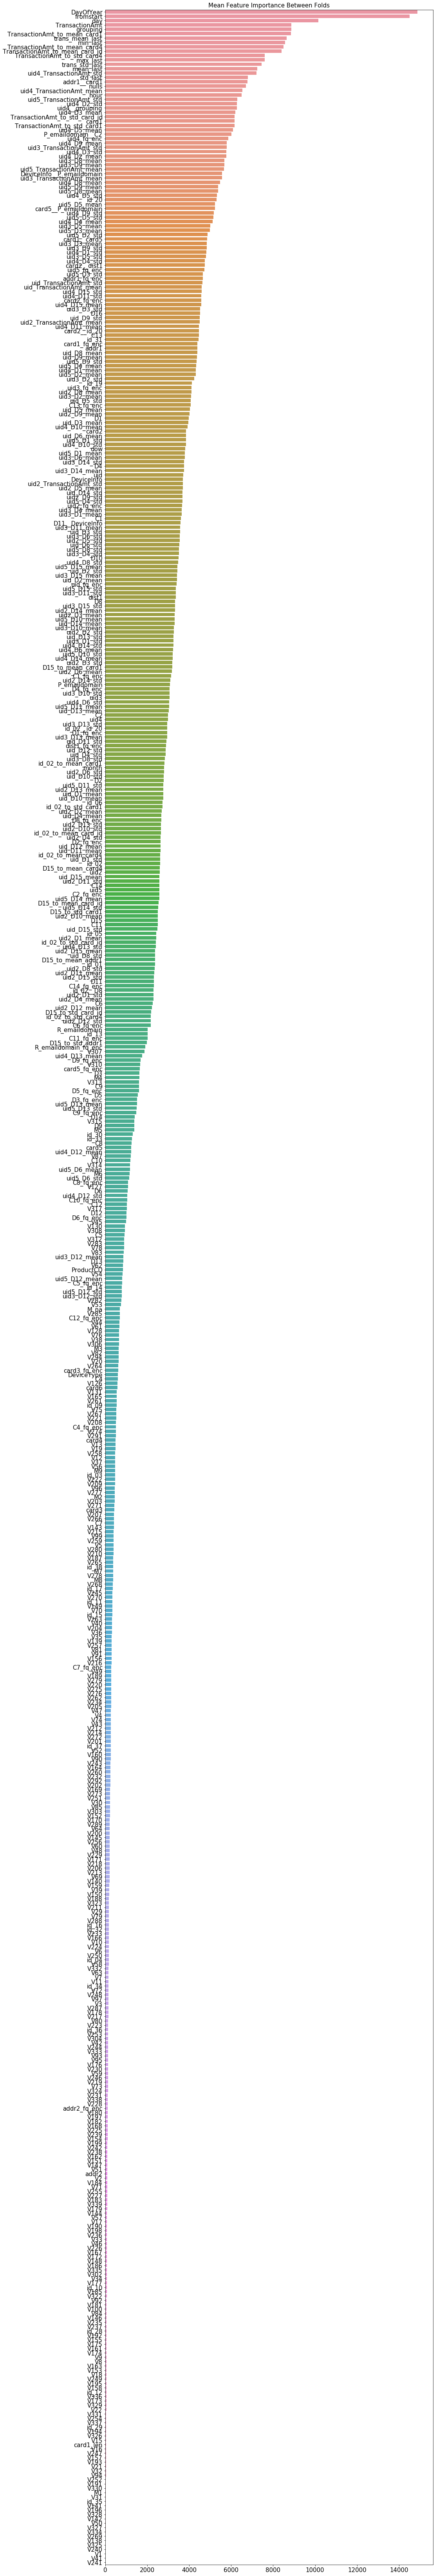

In [32]:
importance['Mean_Importance'] = importance.sum(axis=1) / folds
importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 120))
sns.barplot(x='Mean_Importance', y=importance.index, data=importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Mean Feature Importance Between Folds', size=15)

plt.show()